In this notebook I will try to unlearn points that do not even exist in the dataset for Bayseian Linear Regression

In [109]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import torch
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [110]:
# Dataset generation
def generate_dataset(theta0 , theta1 , n , var):
    x = torch.linspace(-10 , 10 , n)
    # y = theta1*x + theta0 + torch.distributions.Normal(0 , var).sample(x.shape)
    y = theta1*x + theta0 
    return x , y

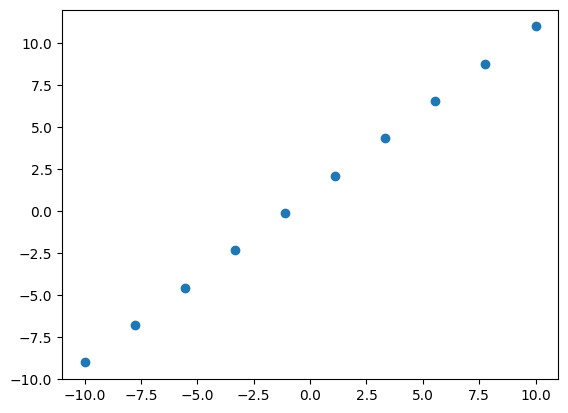

In [111]:
# Dataset generation
n = 10
var_data = 1
X , Y = generate_dataset(1 , 1 , n , var_data)


plt.scatter(X , Y)

In [112]:
# Make X a nx2 matrix by adding a column of ones
X = torch.stack([torch.ones(n) , X] , dim = 1)

In [113]:
def prior(mean , cov):
    return torch.distributions.MultivariateNormal(mean, cov)

In [114]:
def posterior(mean , cov):
    return torch.distributions.MultivariateNormal(mean , cov)

In [115]:
def plot_contour(dist):
    x = torch.linspace(-5, 5, 1000)
    y = torch.linspace(-5, 5, 1000)
    X, Y = torch.meshgrid(x, y)
    XY = torch.stack([X, Y], dim=-1)
    Z = torch.exp(dist.log_prob(XY))
    mean = dist.mean
    plt.contourf(X, Y, Z , levels = 20 , cmap = 'magma')
    plt.scatter(mean[0] , mean[1] , color = 'red')
    plt.text(mean[0] , mean[1] , "Mean: " + str(round(mean[0].item() , 2)) + ", " + str(round(mean[1].item() , 2)) , color = 'white')
    plt.xlabel("theta0")
    plt.ylabel("theta1")
    plt.colorbar()
    plt.show()

In [117]:
mean_prior = torch.tensor([0.0 , 0.0])
cov_prior = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
var_likelihood = 1

In [121]:
Y = Y.reshape(10 , 1)
mean_prior = mean_prior.reshape(2 , 1)

torch.Size([2, 2])


In [126]:
cov_posterior = torch.linalg.inv(torch.linalg.inv(cov_prior) + (1/var_likelihood)*torch.matmul(X.T , X))
mean_posterior = torch.matmul(cov_posterior , (torch.linalg.inv(cov_prior)@mean_prior + (1/var_likelihood)*torch.matmul(X.T , Y)))
mean_posterior = mean_posterior.reshape(2)
mean_prior = mean_prior.reshape(2)
prior_dist = prior(mean_prior , cov_prior)
posterior_dist = posterior(mean_posterior , cov_posterior)

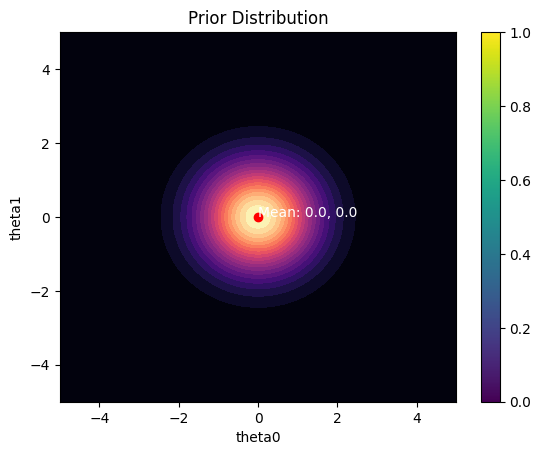

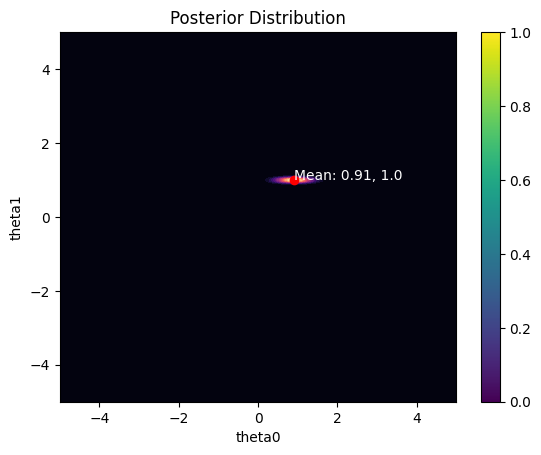

In [127]:
plt.title("Prior Distribution")
plot_contour(prior_dist)
plt.title("Posterior Distribution")
plot_contour(posterior_dist)
plt.show()

In [131]:
def predictive_dist(x , mean_pos , cov_pos , var_likelihood):
    x.reshape(1 , 2)
    mean_pos.reshape(1 , 2)
    return torch.distributions.Normal(torch.matmul(x , mean_pos.T) , var_likelihood + torch.matmul(x , torch.matmul(cov_pos , x.T)))

In [132]:
prediction_dists = []
for i in range(n):
    prediction_dists.append(predictive_dist(X[i] , mean_posterior , cov_posterior , var_likelihood))

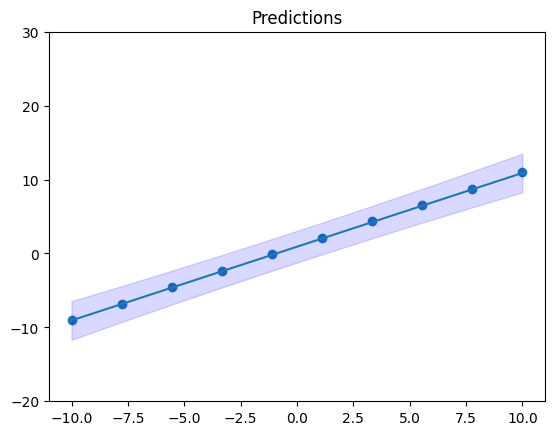

In [133]:
# Plot the prediction as a gradient with the color opacity how confident the model is
def plot_predictions(prediction_dists , X , Y):
    x_new = X[:,1]  
    plt.scatter(x_new , Y)
    y_mean = []
    y_var = []
    for i in range(n):
        dist = prediction_dists[i]
        y_mean.append(dist.mean)
        y_var.append(dist.variance)

    plt.plot(x_new , y_mean)
    y_upper = []
    y_lower = []
    for i in range(n):
        y_upper.append((y_mean[i] + 1.96*np.sqrt(y_var[i])))
        y_lower.append((y_mean[i] - 1.96*np.sqrt(y_var[i])))
    plt.fill_between(x_new , y_upper , y_lower , color = 'blue' , alpha = 0.15)
    plt.ylim(-20 , 30)
    plt.title("Predictions")
    plt.show()

plot_predictions(prediction_dists , X , Y)

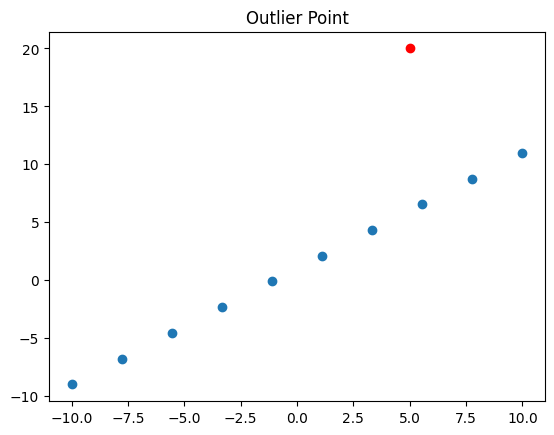

In [148]:
# Generating an outlier point
x_outlier = torch.tensor([1.0 , 5.0])
y_outlier = torch.tensor([20.0])

#Plottting the outlier point
plt.scatter(X[:,1] , Y)
plt.scatter(x_outlier[1] , y_outlier , color = 'red')
plt.title("Outlier Point")
plt.show()

Let's unlearn this new point that does not even exist in the dataset

In [149]:
x_outlier = x_outlier.reshape(1 , 2)
y_outlier = y_outlier.reshape(1 , 1)

In [136]:
mean_posterior = mean_posterior.reshape(1 , 2)

In [137]:
# Unlearning the outlier point

unlearned_posterior_cov = torch.linalg.inv(torch.linalg.inv(cov_posterior) - (1/var_likelihood)*torch.matmul(x_outlier.T , x_outlier))
unlearned_posterior_mean = torch.matmul(unlearned_posterior_cov , (torch.linalg.inv(cov_posterior)@mean_posterior.T) - (1/var_likelihood)*torch.matmul(x_outlier.T , y_outlier))

In [142]:
unlearned_posterior_mean = unlearned_posterior_mean.reshape(2)
mean_posterior = mean_posterior.reshape(2)

In [140]:
unleaned_posterior = posterior(unlearned_posterior_mean , unlearned_posterior_cov)

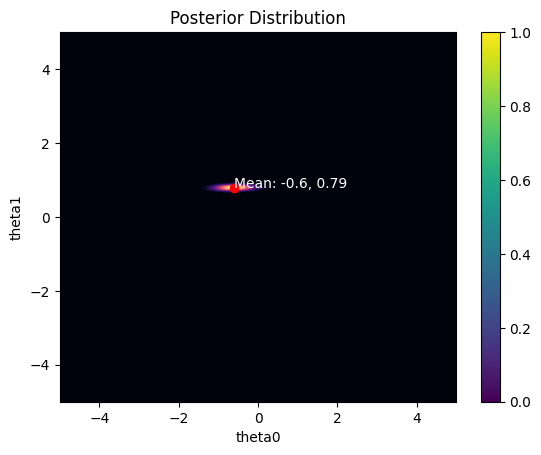

In [141]:
plt.title("Posterior Distribution")
plot_contour(unleaned_posterior)
plt.show()

In [143]:
prediction_dists_new = []
for i in range(n):
    prediction_dists_new.append(predictive_dist(X[i] , unlearned_posterior_mean , unlearned_posterior_cov , var_likelihood))

In [146]:
x_outlier

tensor([[1., 5.]])

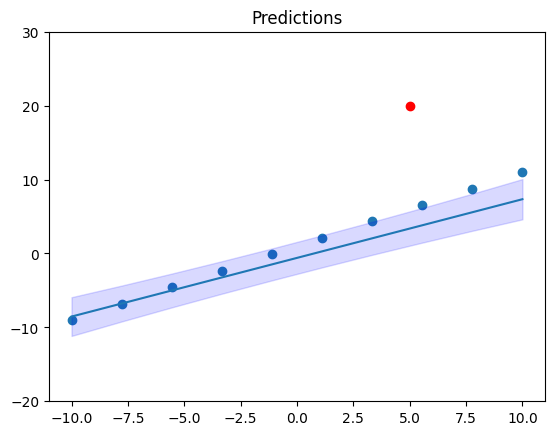

In [151]:
plt.scatter(x_outlier[0][1] , y_outlier , color = 'red')
plot_predictions(prediction_dists_new , X , Y)